# 0. Setup

## Notebook setup`

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

from catboost import CatBoostRegressor

import statsmodels

RANDOM_STATE = 42

In [2]:
# Chart style settings
import matplotlib.style as style
style.use({
    'font.family': 'Monospace',
    'font.size': 10,
})

In [3]:
# Data folders
from pathlib import Path

raw_data_dir = Path.cwd().parent / "data" / "raw"
raw_data_dir.mkdir(parents=True, exist_ok=True)

processed_data_dir = Path.cwd().parent / "data" / "processed"
processed_data_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Spans for time series charts
def add_event_spans(ax):
    return {
        'covid1': ax.axvspan(pd.Timestamp('2020-03'), pd.Timestamp('2020-05'),
                             color="#FE7B4BA0", alpha=0.2, label='1st COVID lock-down'),
        'covid2': ax.axvspan(pd.Timestamp('2020-11'), pd.Timestamp('2020-12'),
                             color="#FE7B4BA0", alpha=0.2, label='2nd COVID lock-down'),
        'covid3': ax.axvspan(pd.Timestamp('2021-01'), pd.Timestamp('2021-04'),
                             color="#FE7B4BA0", alpha=0.2, label='3rd COVID lock-down'),
        'energy': ax.axvspan(pd.Timestamp('2021-10'), pd.Timestamp('2022-10'),
                             color="#FB3B38", alpha=0.2, label='Energy-price crisis')
    }

# 1. TabPFN

### Data preparation

In [5]:
import tabpfn_client
import dotenv

dotenv.load_dotenv()
token = dotenv.get_key(dotenv.find_dotenv(), "PRIORLABS_API_KEY")
tabpfn_client.set_access_token(token)

In [7]:
from autogluon.timeseries import TimeSeriesDataFrame

data_path = processed_data_dir / "model_data.pkl"
meta_path = processed_data_dir / "meta_data.pkl"

df = pd.read_pickle(data_path)
df_reset = df.reset_index()
df_reset = df_reset.rename(columns={'online_retail_sales_share': 'target'})
df_reset['item_id'] = 'retail_series'

tsdf = TimeSeriesDataFrame.from_data_frame(
    df_reset,
    id_column="item_id",
    timestamp_column="date",
    static_features_df=None
)

tsdf.head()

target  cpi_inf  rpi_ex_cpi  eff_fx_inf    cci  \
item_id       timestamp                                                    
retail_series 2015-01-31    12.8  0.30303       156.1    2.690870  102.0   
              2015-02-28    11.7  0.00000       157.2    5.020539  102.2   
              2015-03-31    11.7  0.00000       157.4    5.666404  102.4   
              2015-04-30    12.2 -0.19980       158.1    4.593277  102.4   
              2015-05-31    11.7  0.10000       158.4    5.130730  102.3   

                          boe_rate  d_cov  d_post  
item_id       timestamp                            
retail_series 2015-01-31       0.5      0       0  
              2015-02-28       0.5      0       0  
              2015-03-31       0.5      0       0  
              2015-04-30       0.5      0       0  
              2015-05-31       0.5      0       0

In [ ]:
"""
from tsfeatures import tsfeatures

# Prepare data for tsfeatures (needs: unique_id, ds, y format)
panel_data = pd.DataFrame({
    'unique_id': 'series1',
    'ds': df.index,
    'y': df['online_retail_sales_share']
}).dropna()

# Extract all features at once with monthly frequency
features = tsfeatures(panel_data, freq=12)

# Map tsfeatures output to desired feature names
feature_mapping = {
    'seasonal_strength': 'seasonal_strength',
    'trend': 'trend_strength',
    'spike': 'spikiness',
    'peak': 'peak',
    'trough': 'trough',
    'x_acf1': 'acf1',
    'seas_acf1': 'acf12',
    'unitroot_kpss': 'unitroot_kpss',
    'entropy': 'entropy'
}

# Add features to original DataFrame
for tsf_name, new_name in feature_mapping.items():
    if tsf_name in features.columns:
        df[new_name] = features[tsf_name].iloc[0]
    else:
        df[new_name] = np.nan

# Add stl_features flag
df['stl_features'] = 1 if 'seasonal_strength' in features.columns else 0

print("Added features:", list(feature_mapping.values()) + ['stl_features'])
"""

Training data shape: (115, 8)
Groundtruth data shape: (127, 8)
Test data shape: (12, 8)
Prediction length: 12


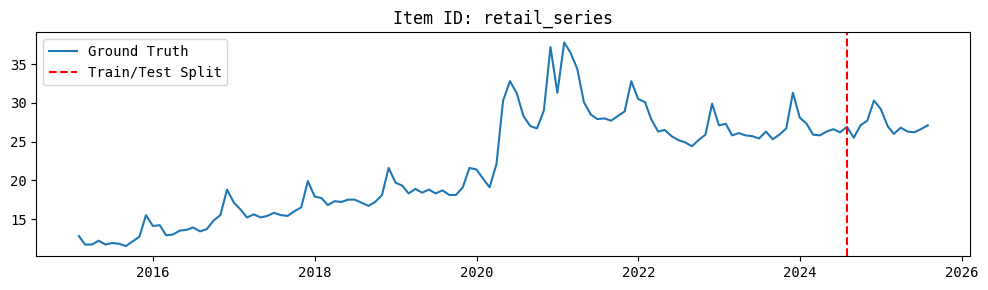

In [30]:
from tabpfn_time_series.plot import plot_actual_ts
from tabpfn_time_series.data_preparation import generate_test_X
import numpy as np

horizon = 12
num_time_series_subset = 1

train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=horizon)
# test_tsdf = generate_test_X(train_tsdf, horizon)

test_tsdf = test_tsdf_ground_truth[-12:].copy()
test_tsdf['target'] = np.nan

print(f"Training data shape: {train_tsdf.shape}")
print(f"Groundtruth data shape: {test_tsdf_ground_truth.shape}")
print(f"Test data shape: {test_tsdf.shape}")
print(f"Prediction length: {horizon}")

plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

In [31]:
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode

predictor = TabPFNTimeSeriesPredictor(tabpfn_mode=TabPFNMode.CLIENT)

pred = predictor.predict(train_tsdf, test_tsdf)

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 538.21it/s]
Processing: 100%|██████████| [00:01<00:00]


ValueError: could not convert string to float: 'cpi_inf'

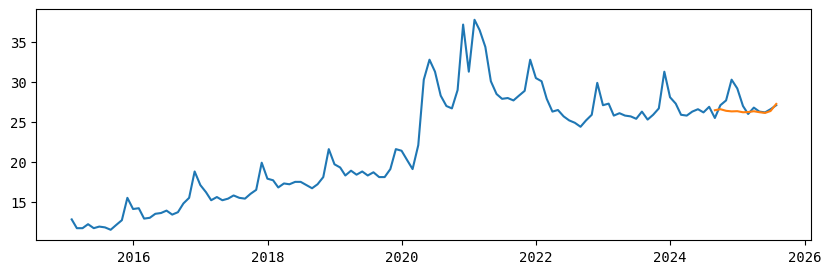

In [35]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts
pred_for_plot = pred.copy()
pred_for_plot.columns = [str(col) if col != 'target' else col for col in pred_for_plot.columns]


plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf_ground_truth,
    pred=pred_for_plot,
)

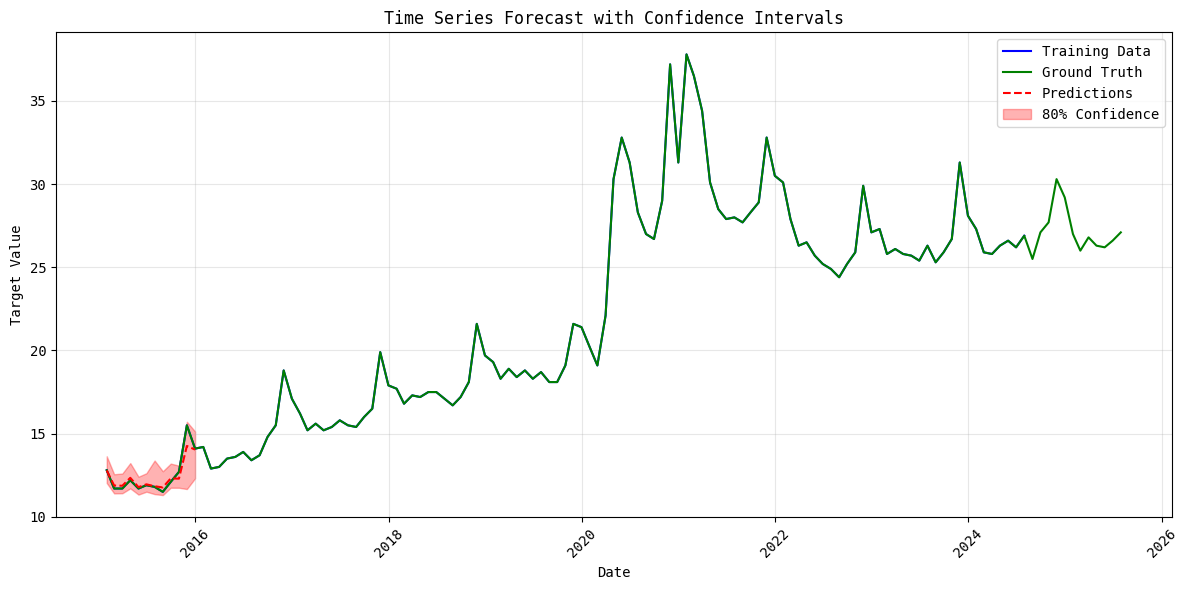

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Create the plot manually
fig, ax = plt.subplots(figsize=(12, 6))

# Plot training data
train_data = train_tsdf.loc['retail_series', 'target']
ax.plot(train_data.index, train_data.values, label='Training Data', color='blue')

# Plot ground truth test data
test_ground_truth = test_tsdf_ground_truth.loc['retail_series', 'target']
ax.plot(test_ground_truth.index, test_ground_truth.values, label='Ground Truth', color='green')

# Plot predictions (point estimates)
pred_data = pred_for_plot.loc['retail_series', 'target']
ax.plot(pred_data.index, pred_data.values, label='Predictions', color='red', linestyle='--')

# Add confidence bands (using 0.1 and 0.9 quantiles)
lower_bound = pred_for_plot.loc['retail_series', '0.1']
upper_bound = pred_for_plot.loc['retail_series', '0.9']
ax.fill_between(pred_data.index, lower_bound, upper_bound, alpha=0.3, color='red', label='80% Confidence')

ax.set_xlabel('Date')
ax.set_ylabel('Target Value')
ax.set_title('Time Series Forecast with Confidence Intervals')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()